# Treebank NER with Bi-LSTM-CRF on morphemes

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [6]:
from conlleval import evaluate

In [7]:
from ner_utils import *

Using TensorFlow backend.


## Get morpheme data

In [8]:
yap_dev = pd.read_csv('new_yap_outputs/yap_dev.csv.gz', compression='gzip')
yap_test = pd.read_csv('new_yap_outputs/yap_test.csv.gz', compression='gzip')

In [9]:
dropped = [5438, 5444, 5445, 5446, 5448, 5449, 5450, 5451, 5453, 5459]

In [10]:
spdf = pd.read_csv('align/spdf_fixed.csv.gz', compression='gzip')
spdf = spdf[(~spdf.sent_id.isin(dropped))]

/home/dan/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
spdf.head()

,id,form,lemma,upostag,xpostag,feats,token_id,sent_id,token_str,global_sent_id,...,deps,misc,ner_escaped,set,duplicate_sent_id,very_similar_sent_id,biose_layer0,biose_layer1,biose_layer2,biose_layer3
0,1,עשרות,עשר,CDT,CDT,gen=F|num=P,1,1,עשרות,1,...,_,_,_,dev,NaN,NaN,O,O,O,O
1,2,אנשים,איש,NN,NN,gen=M|num=P,2,1,אנשים,1,...,_,_,_,dev,NaN,NaN,O,O,O,O
2,3,מגיעים,הגיע,BN,BN,gen=M|num=P|per=A|HebBinyan=HIFIL,3,1,מגיעים,1,...,_,_,_,dev,NaN,NaN,O,O,O,O
3,4,מ,מ,PREPOSITION,PREPOSITION,_,4,1,מתאילנד,1,...,_,_,_,dev,NaN,NaN,O,O,O,O
4,5,תאילנד,תאילנד,NNP,NNP,_,4,1,מתאילנד,1,...,_,_,GPE,dev,NaN,NaN,S-GPE,O,O,O


In [12]:
yap_dev.head()

,id,form,lemma,upostag,xpostag,head,deprel,deps,misc,sent,misc_token_id,misc_token_str,feats_gen,feats_num,feats_per,feats_tense,feats_suf_gen,feats_suf_num,feats_suf_per,sent_id
0,1,עשרות,עשר,CDT,CDT,2,num,_,_,1,1,עשרות,F,P,NaN,NaN,NaN,NaN,NaN,1
1,2,אנשים,איש,NN,NN,3,subj,_,_,1,2,אנשים,M,P,NaN,NaN,NaN,NaN,NaN,1
2,3,מגיעים,הגיע,BN,BN,14,conj,_,_,1,3,מגיעים,M,P,A,NaN,NaN,NaN,NaN,1
3,4,מ,מ,PREPOSITION,PREPOSITION,3,comp,_,_,1,4,מתאילנד,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,5,תאילנד,תאילנד,NNP,NNP,4,pobj,_,_,1,4,מתאילנד,F,S,NaN,NaN,NaN,NaN,NaN,1


In [13]:
yap_dev_sents =  yap_dev.groupby('sent_id')[['form', 'upostag']].apply(lambda x: x.values.tolist())
yap_dev_sents.head()

sent_id
1    [[עשרות, CDT], [אנשים, NN], [מגיעים, BN], [מ, ...
2    [[תופעה, NN], [זו, PRP], [התבררה, VB], [אתמול,...
3    [[יו"ר, NNT], [ה, DEF], [וועדה, NN], [,, yyCM]...
4    [[מ, PREPOSITION], [צד, NN], [אחד, CD], [רוצה,...
5    [[נמיר, NNP], [הודיעה, VB], [כי, CC], [תפנה, V...
dtype: object

In [14]:
yap_test_sents =  yap_test.groupby('sent_id')[['form', 'upostag']].apply(lambda x: x.values.tolist())
yap_test_sents.head()

sent_id
5439    [[ה, DEF], [כל, DTT], [נושאים, NN], [עמם, VB],...
5440    [[אומר, NNT], [מזכיר, NNT], [ה, DEF], [תק"ם, N...
5441    [[לא, RB], [ייתכן, MD], [ש, REL], [עולה, NN], ...
5442    [[לא, RB], [ייתכן, MD], [ש, REL], [הוא, PRP], ...
5443    [[לכן, CC], [קבענו, VB], [עיקרון, NN], [ש, REL...
dtype: object

In [15]:
gold_dev  = spdf[spdf.set=='dev']
gold_train = spdf[spdf.set=='train']
gold_test = spdf[spdf.set=='test']

In [16]:
gold_dev_sents = gold_dev.groupby('sent_id')[['form', 'upostag', 'biose']].apply(lambda x: x.values.tolist())
gold_train_sents = gold_train.groupby('sent_id')[['form', 'upostag', 'biose']].apply(lambda x: x.values.tolist())
gold_test_sents = gold_test.groupby('sent_id')[['form', 'upostag', 'biose']].apply(lambda x: x.values.tolist())
gold_test_sents.head()

sent_id
5439    [[הכל, NN, O], [נושאים, BN, O], [עמ, IN, O], [...
5440    [[אומר, BN, O], [מזכיר, NNT, O], [התק"ם, NNP, ...
5441    [[לא, RB, O], [ייתכן, MD, O], [ש, REL, O], [עו...
5442    [[לא, RB, O], [ייתכן, MD, O], [ש, REL, O], [הו...
5443    [[לכן, CC, O], [קבענו, VB, O], [עיקרון, NN, O]...
dtype: object

In [17]:
def write_conll_output(sents, output_path):
    with open(output_path, 'w', encoding='utf-8') as f:
        for s in sents:
            for m, p, n in s:
                f.write(m +' [POS]' + p + ' ' + n + '\n')
            f.write('\n')
            
write_conll_output(gold_dev_sents, 'data/ner/morph_dev_pos_biose.bmes')
write_conll_output(gold_train_sents, 'data/ner/morph_train_pos_biose.bmes')
write_conll_output(gold_test_sents, 'data/ner/morph_test_pos_biose.bmes')

In [18]:
words = list(set(spdf.form.values)|set(yap_dev.form.values)|set(yap_test.form.values))
n_words = len(words); n_words

18465

In [19]:
tags = list(set(spdf.biose.values))
n_tags = len(tags); n_tags

37

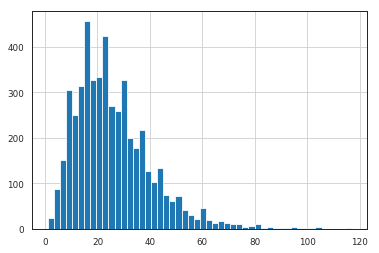

In [20]:
gold_train.groupby('sent_id').size().hist(bins=50)

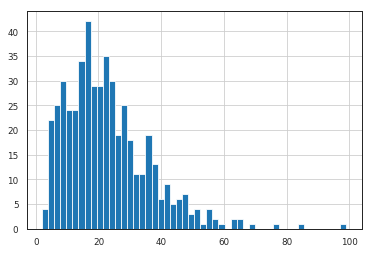

In [21]:
yap_dev.groupby('sent_id').size().hist(bins=50)

In [22]:
max_len = 80
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [23]:
from keras.preprocessing.sequence import pad_sequences
X_gold_train = [[word2idx[w[0]] for w in s] for s in gold_train_sents]
X_gold_dev   = [[word2idx[w[0]] for w in s] for s in gold_dev_sents]
X_gold_test  = [[word2idx[w[0]] for w in s] for s in gold_test_sents]
X_yap_dev    = [[word2idx[w[0]] for w in s] for s in yap_dev_sents]
X_yap_test   = [[word2idx[w[0]] for w in s] for s in yap_test_sents]

In [24]:
X_gold_train = pad_sequences(maxlen=max_len, sequences=X_gold_train, value=word2idx["PAD"], padding='post', truncating='post')
X_gold_dev   = pad_sequences(maxlen=max_len, sequences=X_gold_dev  , value=word2idx["PAD"], padding='post', truncating='post')
X_gold_test  = pad_sequences(maxlen=max_len, sequences=X_gold_test , value=word2idx["PAD"], padding='post', truncating='post')
X_yap_dev    = pad_sequences(maxlen=max_len, sequences=X_yap_dev   , value=word2idx["PAD"], padding='post', truncating='post')
X_yap_test   = pad_sequences(maxlen=max_len, sequences=X_yap_test  , value=word2idx["PAD"], padding='post', truncating='post')
X_gold_train[0]

array([ 5379,  8962, 16515, 10119,  2599, 18298,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [25]:
pos = list(set(spdf.upostag.values)|set(yap_dev.upostag.values)|set(yap_test.upostag.values))
n_pos = len(pos); n_pos

52

In [26]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0

In [27]:
from keras.preprocessing.sequence import pad_sequences
X_pos_gold_train = [[pos2idx[w[1]] for w in s] for s in gold_train_sents]
X_pos_gold_dev   = [[pos2idx[w[1]] for w in s] for s in gold_dev_sents]
X_pos_gold_test  = [[pos2idx[w[1]] for w in s] for s in gold_test_sents]
X_pos_yap_dev    = [[pos2idx[w[1]] for w in s] for s in yap_dev_sents]
X_pos_yap_test   = [[pos2idx[w[1]] for w in s] for s in yap_test_sents]

In [28]:
X_pos_gold_train = pad_sequences(maxlen=max_len, sequences=X_pos_gold_train, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_dev   = pad_sequences(maxlen=max_len, sequences=X_pos_gold_dev  , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_test  = pad_sequences(maxlen=max_len, sequences=X_pos_gold_test , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_yap_dev    = pad_sequences(maxlen=max_len, sequences=X_pos_yap_dev   , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_yap_test   = pad_sequences(maxlen=max_len, sequences=X_pos_yap_test  , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_train[0]

array([35, 52, 26, 27, 46, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [29]:
from keras.preprocessing.sequence import pad_sequences
y_gold_train = [[tag2idx[w[2]] for w in s] for s in gold_train_sents]
y_gold_dev   = [[tag2idx[w[2]] for w in s] for s in gold_dev_sents]
y_gold_test  = [[tag2idx[w[2]] for w in s] for s in gold_test_sents]

In [30]:
y_numer_gold_train = pad_sequences(maxlen=max_len, sequences=y_gold_train, value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_dev   = pad_sequences(maxlen=max_len, sequences=y_gold_dev  , value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_test  = pad_sequences(maxlen=max_len, sequences=y_gold_test , value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_train[0]

array([19, 19, 19, 19, 19, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [31]:
from keras.utils import to_categorical
y_gold_train = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_train]
y_gold_dev   = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_dev  ]
y_gold_test  = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_test ]

y_gold_train[0].shape

(80, 38)

In [32]:
validation_split = len(X_gold_dev) / (len(X_gold_train)+len(X_gold_dev))
validation_split

0.09196247930844216

In [33]:
splits = [[X_gold_train, X_gold_dev,
           y_gold_train, y_gold_dev,
           X_pos_gold_train, X_pos_gold_dev ]]

### Prep char input

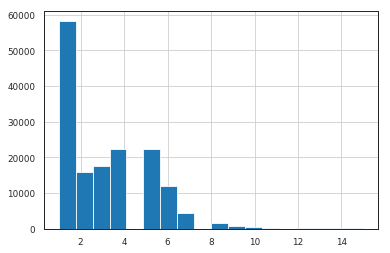

In [34]:
spdf.form.apply(len).hist(bins=18)

In [35]:
max_len_char = 12

In [36]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

50


In [37]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [38]:
def get_X_char(sents):
    X_char = []
    for sentence in sents:
        sent_seq = []
        for i in range(max_len):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                except:
                    word_seq.append(char2idx.get("PAD"))
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))
    return X_char

In [39]:
X_char_gold_dev   = get_X_char(gold_dev_sents  )
X_char_gold_train = get_X_char(gold_train_sents)
X_char_gold_test  = get_X_char(gold_test_sents )
X_char_yap_dev    = get_X_char(yap_dev_sents   )
X_char_yap_test   = get_X_char(yap_test_sents  )



splits_char = [[X_char_gold_train, X_char_gold_dev,
                y_gold_train, y_gold_dev]]

## Embeddings

In [40]:
embedding_paths

{'yap_w2v_sg': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.yap_form.word2vec_skipgram.txt',
 'yap_w2v_cbow': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.yap_form.word2vec_cbow.txt',
 'yap_glove': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.yap_form.glove.txt',
 'yap_ft_sg': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.yap_form.fasttext_skipgram.model.vec',
 'yap_ft_cbow': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.yap_form.fasttext_cbow.model.vec',
 'token_w2v_sg': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.tokenized.word2vec_skipgram.txt',
 'token_w2v_cbow': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.tokenized.word2vec_cbow.txt',
 'token_glove': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.tokenized.glove.txt',
 'token_ft_sg': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.tokenized.fasttext_skipgram.model.vec',
 'token_ft_cbow': '../wordembedding-hebrew/vectors_orig_tok/wikipedia.tokenized.fasttext_cbow.model.vec',

In [41]:
exclude = ['tuned', 'cbow', 'token']
include = 'NONE'

In [42]:
embedding_mats = {}
for emb_name, emb_path in embedding_paths.items():
    skip=False
    if include not in emb_name:
        continue
        
    for exc in exclude:
        if exc in emb_path:
            skip=True
    if skip:
        continue
    embedding_mats[emb_name] = get_embedding_matrix(emb_path, word2idx)

## Model building

In [52]:
from ner_utils import *

In [53]:
configs = build_configs(base_configs_stack_no_emb, embedding_mats)
configs     

[{'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': True,
  'use_char': True,
  'crf': True,
  'use_pos': False,
  'trainable': True,
  'stack_lstm': 2},
 {'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': True,
  'use_char': True,
  'crf': True,
  'use_pos': True,
  'trainable': True,
  'stack_lstm': 2}]

In [54]:
for conf in configs:
    conf['patience'] = 10

In [55]:
out_folder = 'results/new_outputs_stack'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [56]:
extra_preds = [(X_gold_test, X_pos_gold_test, X_char_gold_test), 
               (X_yap_dev, X_pos_yap_dev, X_char_yap_dev),
               (X_yap_test, X_pos_yap_test, X_char_yap_test)]

In [57]:
from ner_utils import *

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 12)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 80, 12, 20)   1040        input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 80, 70)       1292690     input_1[0][0]                    
__________________________________________________________________________________________________
time_distr

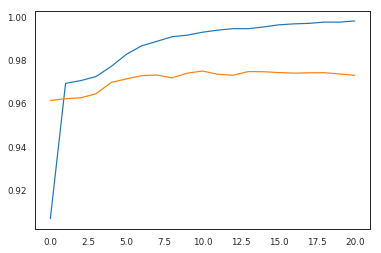

processed 11278 tokens with 498 phrases; found: 289 phrases; correct: 177.
accuracy:  35.39%; (non-O)
accuracy:  93.62%; precision:  61.25%; recall:  35.54%; FB1:  44.98
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
              GPE: precision:  68.09%; recall:  53.33%; FB1:  59.81  94
              LOC: precision:  37.50%; recall:  10.71%; FB1:  16.67  8
              ORG: precision:  48.24%; recall:  34.45%; FB1:  40.20  85
              PER: precision:  70.41%; recall:  35.75%; FB1:  47.42  98
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to            

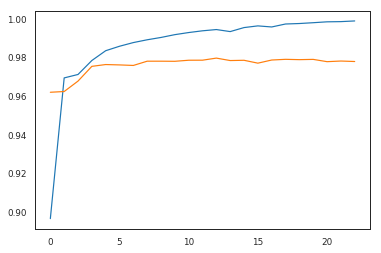

processed 11278 tokens with 498 phrases; found: 481 phrases; correct: 284.
accuracy:  50.89%; (non-O)
accuracy:  94.95%; precision:  59.04%; recall:  57.03%; FB1:  58.02
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  74.44%; recall:  55.83%; FB1:  63.81  90
              LOC: precision:  32.43%; recall:  42.86%; FB1:  36.92  37
              ORG: precision:  41.59%; recall:  39.50%; FB1:  40.52  113
              PER: precision:  65.83%; recall:  81.87%; FB1:  72.98  240
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0


In [58]:
configs, results, preds, histories = run_models(configs, splits, splits_char, embedding_mats, 
                                                words, max_len, n_words, idx2word, idx2tag,
                                                n_tags, max_len_char, n_pos, n_chars,
                                                run_name='treebank_morphemes_stack_no_emb1', out_folder=out_folder,
                                                skip_if_model_exists=True,
                                                validation_split=validation_split,
                                                extra_predictions=extra_preds,
                                                )

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
1

###### 